In [3]:
from vowpalwabbit import pyvw
import random
import matplotlib.pyplot as plt
import pandas as pd
import itertools
import numpy as np

In [4]:
USER_OPENED = -1
USER_IGNORED = 0
actions = ['title_1', 'title_2', 'title_3','title_4']
genders = ['Male', 'Female']
time_of_days = ['morning', 'afternoon']

# display preference matrix
def get_preference_matrix(cost_fun):
    def expand_grid(data_dict):
        rows = itertools.product(*data_dict.values())
        return pd.DataFrame.from_records(rows, columns=data_dict.keys())

    df = expand_grid({'users':users, 'times_of_day': times_of_day, 'actions': actions})
    df['cost'] = df.apply(lambda r: cost_fun({'user': r[0], 'time_of_day': r[1]}, r[2]), axis=1)

    return df.pivot_table(index=['users', 'times_of_day'], 
            columns='actions', 
            values='cost')

In [101]:
def get_cost(context, action):
    if context['user'] == "Male":
        if context['time_of_day'] == "morning" and action == 'title_1':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'title_2':
            return USER_OPENED
        else:
            return USER_IGNORED
    elif context['user'] == "Female":
        if context['time_of_day'] == "morning" and action == 'title_2':
            return USER_OPENED
        elif context['time_of_day'] == "afternoon" and action == 'title_3':
            return USER_OPENED
        else:
            return USER_IGNORED
# get_preference_matrix(get_cost)

In [102]:
def generate_random_context():
    return {"user": np.random.choice(genders),
           "time_of_day": np.random.choice(time_of_days)}

# this will simply demonstrate a single row in the dataset
context = generate_random_context()
print(context)

action = np.random.choice(actions)
print(action)

print("-----")
# according to our cost function this setup will yield the following result:
print(f"result: {get_cost(context=context, action=action)}")

{'user': 'Male', 'time_of_day': 'morning'}
title_1
-----
result: -1


In [103]:
# now do this a whole lot of times in order to build a dataset
n_rows = int(5000)
dataset = []
for _ in range(n_rows):
    context = generate_random_context()
    action = np.random.choice(actions)
    
    result = get_cost(context=context, action=action)
    
    context['action'] = action
    context['result'] = result
    
    dataset.append(context)


In [104]:
# this simply converts the dataset to a pandas dataframe, and shows some example rows

df = pd.DataFrame(dataset)
df

,user,time_of_day,action,result
0,Female,afternoon,title_4,0
1,Female,afternoon,title_3,-1
2,Male,afternoon,title_2,-1
3,Female,afternoon,title_1,0
4,Female,afternoon,title_3,-1
...,...,...,...,...
4995,Male,afternoon,title_4,0
4996,Male,morning,title_4,0
4997,Male,morning,title_1,-1
4998,Female,afternoon,title_4,0


In [105]:
# now we could use a simple classification technique to model the wether users will open mails or ignore them
# https://scikit-learn.org/stable/modules/tree.html
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

In [106]:
# fix the independent variable
x = df.iloc[:,:-1]
x

,user,time_of_day,action
0,Female,afternoon,title_4
1,Female,afternoon,title_3
2,Male,afternoon,title_2
3,Female,afternoon,title_1
4,Female,afternoon,title_3
...,...,...,...
4995,Male,afternoon,title_4
4996,Male,morning,title_4
4997,Male,morning,title_1
4998,Female,afternoon,title_4


In [107]:
# replace x with true/fale
is_male = (x.iloc[:,0] == "Male").values
is_morning = (x.iloc[:,1] == "morning").values
df2 = pd.DataFrame()
df2['is_male'] = is_male
df2['is_morning'] = is_morning
df2['used_title1'] = (x.iloc[:,2] == "title_1").values
df2['used_title2'] = (x.iloc[:,2] == "title_2").values
df2['used_title3'] = (x.iloc[:,2] == "title_3").values
df2

,is_male,is_morning,used_title1,used_title2,used_title3
0,False,False,False,False,False
1,False,False,False,False,True
2,True,False,False,True,False
3,False,False,True,False,False
4,False,False,False,False,True
...,...,...,...,...,...
4995,True,False,False,False,False
4996,True,True,False,False,False
4997,True,True,True,False,False
4998,False,False,False,False,False


In [108]:
# get the dependent variable
y = df.iloc[:,-1].values
y

array([ 0, -1, -1, ..., -1,  0,  0], dtype=int64)

0.2458


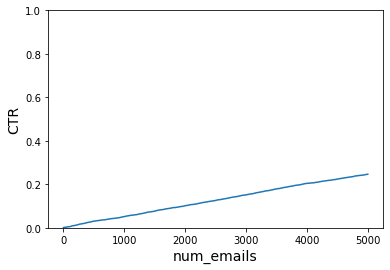

In [109]:
cost = 0
b = []

# for i in range(n_rows):
#     if df['result'][i]== -1:
#         #print (df['user'][i])
#         cost+= -1
#         ctr=-1*cost/n_rows
#         a.append(ctr)
#         print(-1*cost/n_rows)
# # print(ctr)
# # print(-1*cost/n_rows)
for i in range(n_rows):
    a= df['result'][i]
#     print(a)
    #print (df['user'][i])
    cost+= a
    ctr=-1*cost/n_rows
    b.append(ctr)
#     print(-1*cost/n_rows)
print(ctr)

def plot_ctr(num_iterations, ctr):
    plt.plot(range(1,num_iterations+1), ctr)
    plt.xlabel('num_emails', fontsize=14)
    plt.ylabel('CTR', fontsize=14)
    plt.ylim([0,1])
#     plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),fancybox=True, shadow=True, ncol=2)
    
plot_ctr(n_rows, b)

# Decision tree

In [110]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(df2.values, y)

[Text(177.24705882352941, 199.32, 'X[3] <= 0.5\ngini = 0.371\nsamples = 5000\nvalue = [1229, 3771]'),
 Text(98.47058823529412, 163.07999999999998, 'X[2] <= 0.5\ngini = 0.262\nsamples = 3723\nvalue = [576, 3147]'),
 Text(59.082352941176474, 126.83999999999999, 'X[1] <= 0.5\ngini = 0.206\nsamples = 2562\nvalue = [298, 2264]'),
 Text(39.38823529411765, 90.6, 'X[4] <= 0.5\ngini = 0.363\nsamples = 1249\nvalue = [298, 951]'),
 Text(19.694117647058825, 54.359999999999985, 'gini = 0.0\nsamples = 637\nvalue = [0, 637]'),
 Text(59.082352941176474, 54.359999999999985, 'X[0] <= 0.5\ngini = 0.5\nsamples = 612\nvalue = [298, 314]'),
 Text(39.38823529411765, 18.119999999999976, 'gini = 0.0\nsamples = 298\nvalue = [298, 0]'),
 Text(78.7764705882353, 18.119999999999976, 'gini = 0.0\nsamples = 314\nvalue = [0, 314]'),
 Text(78.7764705882353, 90.6, 'gini = 0.0\nsamples = 1313\nvalue = [0, 1313]'),
 Text(137.85882352941178, 126.83999999999999, 'X[0] <= 0.5\ngini = 0.364\nsamples = 1161\nvalue = [278, 883]

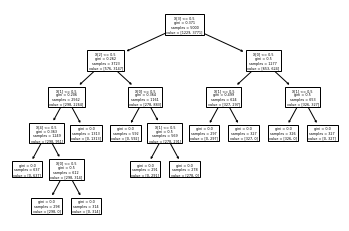

In [111]:
# this is somewhat confusing as the default sci-kit decision tree does not really support categorical attributes
tree.plot_tree(clf) 

In [114]:
# predicted result for female, afternoon title_3 => -1
clf.predict([[0,0,0,0,1]])

array([-1], dtype=int64)

In [117]:
# predicted result for female, afternoon title_1 => 0
clf.predict([[0,0,1,0,0]])

array([0], dtype=int64)

# Logistic regression

In [98]:
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
from sklearn.linear_model import LogisticRegression
clf2 = LogisticRegression(random_state=0).fit(df2.values, y)

In [99]:
# same result for  female, afternoon title_1 => -1
clf2.predict([[0,0,1,0,0]])

array([0], dtype=int64)

In [100]:
# and also result for female, afternoon title_3 => 0
clf2.predict([[0,0,1,0,0]])

array([0], dtype=int64)

# Comparison RL vs supervised learning

This is not supposed to run but this gives an idea how I would handle the comparison

In [74]:
for i in range(n_test_cases):
    
    print("send email")
    context = ...
    print("update rl model")
    
    if i % 100 == 0:
        print("update supervised learning model every x mails")
        
    score_rl = rl_result(context)
    score_supervised = supervised_result(context)


NameError: name 'n_test_cases' is not defined

In [1]:
!vw --help

'vw' is not recognized as an internal or external command,
operable program or batch file.
